In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
#difference are all in the decimal places

In [88]:
#need to preprocess the data frame first and then split dataset
from prepare_data import create_testdata
from preprocessing import preprocessing
#create datasets
df=preprocessing()
features_train,windspeed_train,features_test,windspeed_test=create_testdata(df,'50')

In [89]:
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

In [90]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

In [91]:
df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

In [92]:
features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from sklearn.feature_selection import f_regression, mutual_info_regression

In [8]:
coef=[]
for i in range(25):
    value=scipy.stats.pearsonr(features_train.values[:,i], windspeed_train)
    coef.append(value)

In [10]:
mi = mutual_info_regression(features_train, windspeed_train)
mi /= np.max(mi)


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


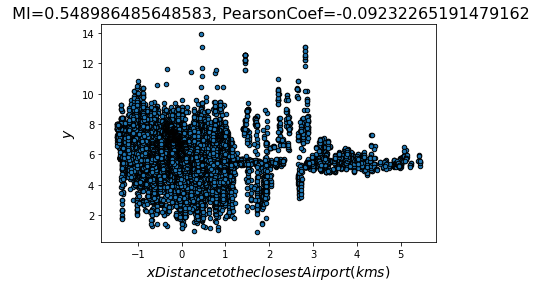

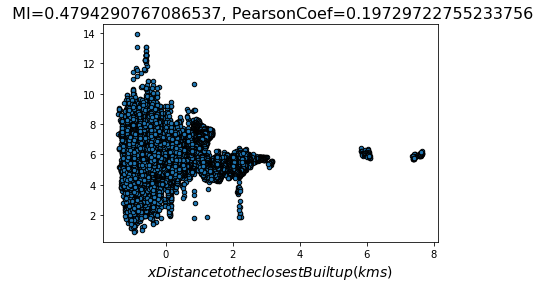

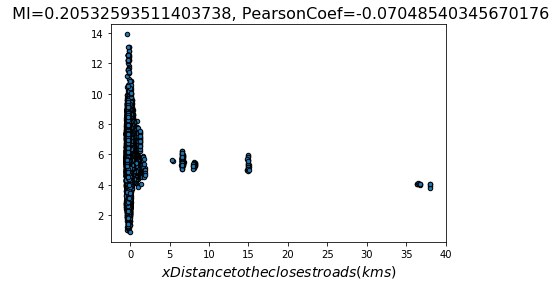

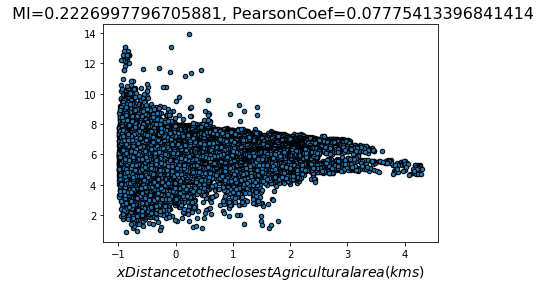

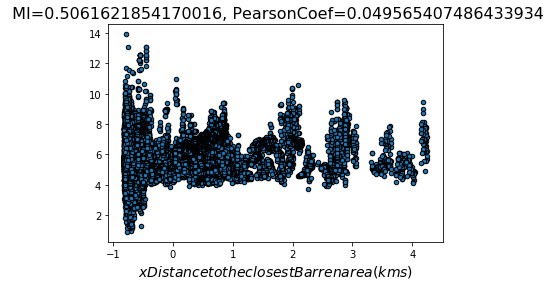

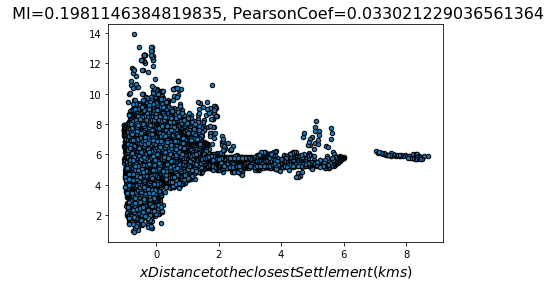

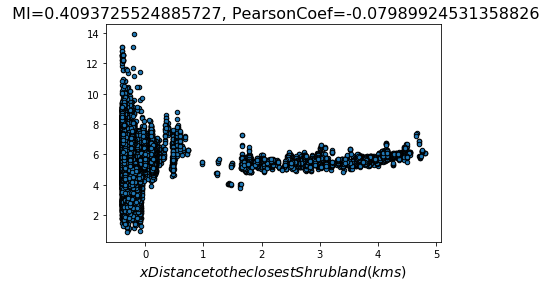

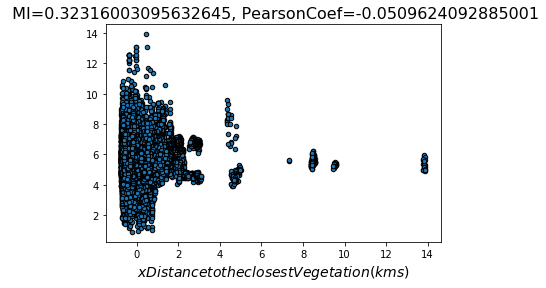

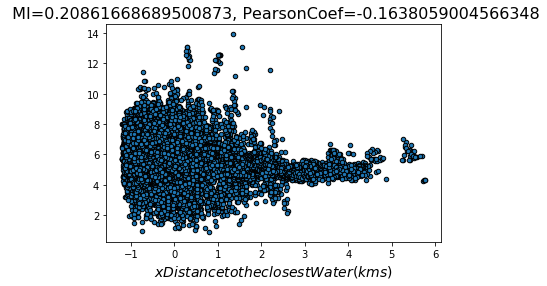

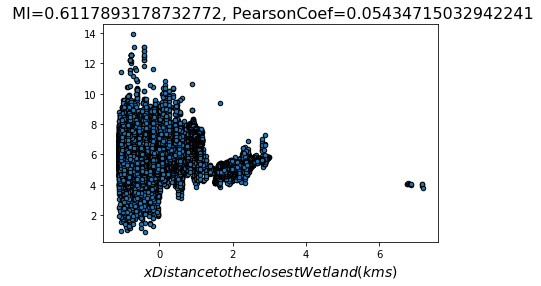

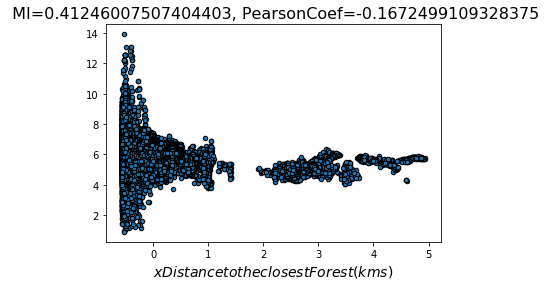

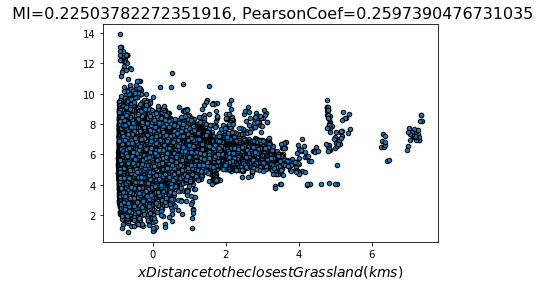

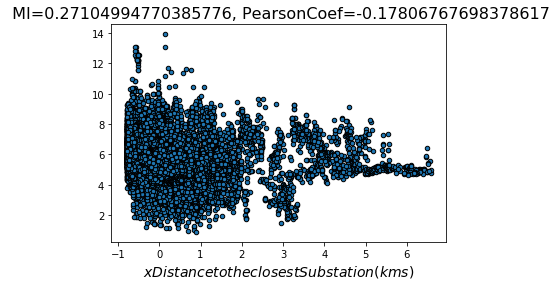

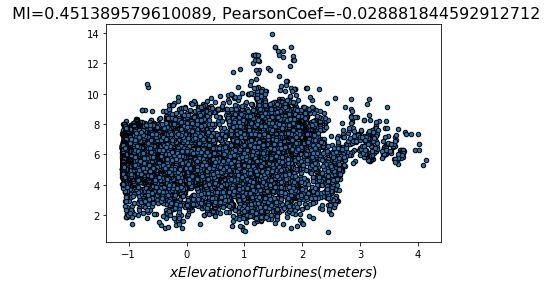

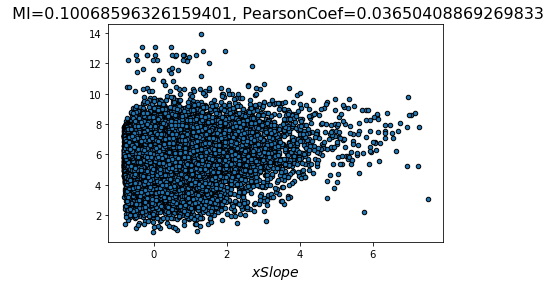

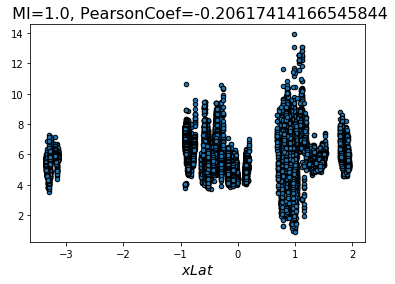

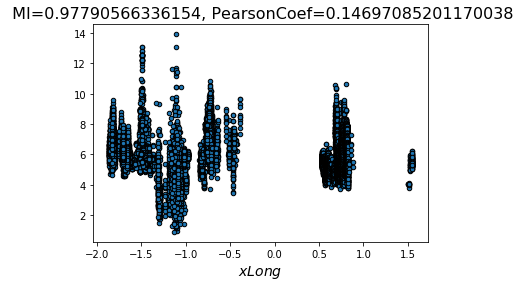

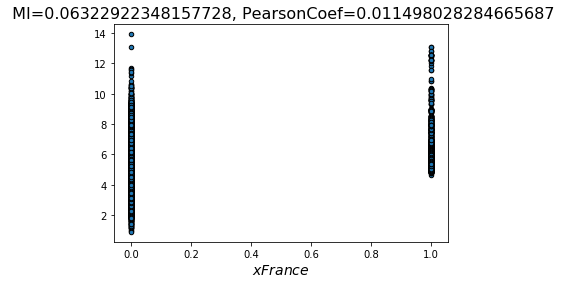

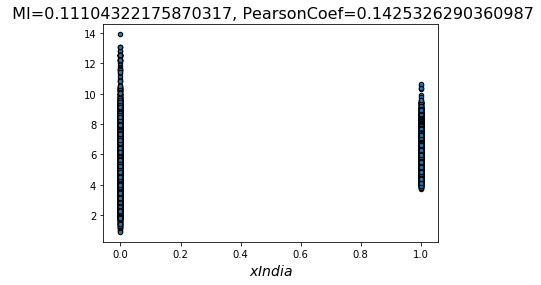

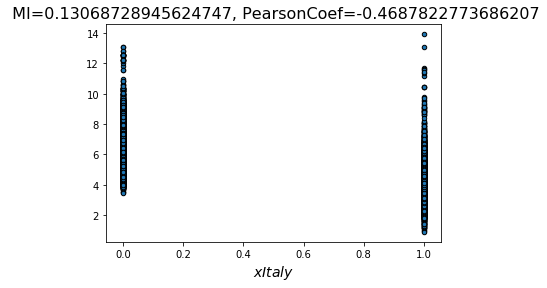

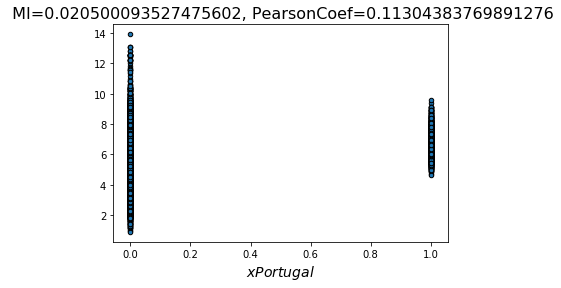

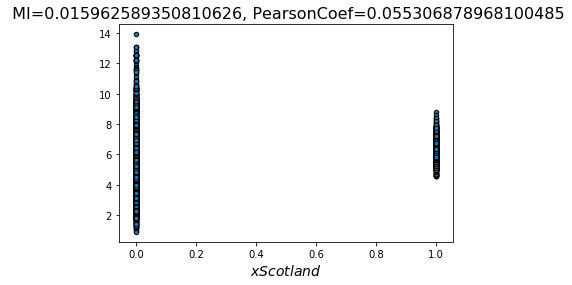

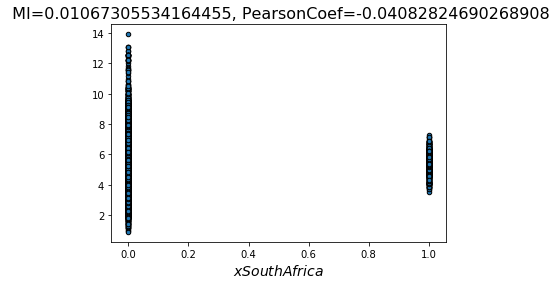

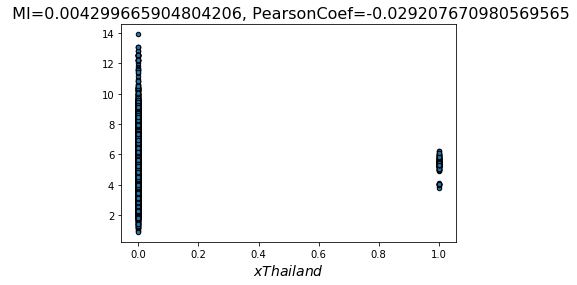

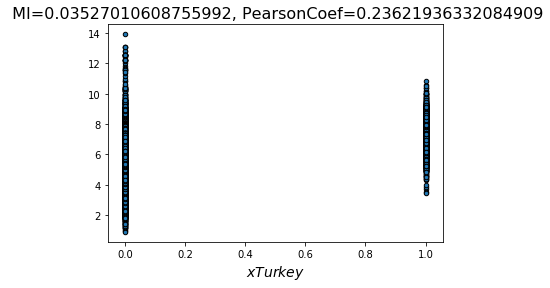

In [11]:
for i in range(25):
    plt.figure()
    plt.scatter(features_train.iloc[:, i], windspeed_train, edgecolor='black', s=20)
    plt.xlabel("$x{}$".format(features_train.columns.values[i]), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title(" MI={}, PearsonCoef={}".format( mi[i],coef[i][0]),
              fontsize=16)
plt.show()

# Baseline model


In [93]:
features_train['y']=windspeed_train

In [94]:
i_variables=[]
for i in range(number-1):
    i_variables.append('X{}'.format(i))
i_variables.append('y')
    

In [95]:
keys = features_train.columns.values
values = i_variables
dictionary = dict(zip(keys, values))

In [96]:
features_train.rename(columns=dictionary,inplace=True)
features_test.rename(columns=dictionary,inplace=True)

In [97]:
columns=features_train.columns.values
formula='y ~ '+columns[0]
number=len(columns)
for i in range(1, number-1):
    formula=formula+' + '+columns[i]

In [53]:
import pymc3 as pm

In [55]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = features_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, X24, X23, X22, X21, X20, X19, X18, X17, X16, X15, X14, X13, X12, X11, X10, X9, X8, X7, X6, X5, X4, X3, X2, X1, X0, Intercept]
100%|██████████| 2500/2500 [33:01<00:00,  1.21it/s]
There were 1997 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.13790358170259448, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1997 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4659011283449415, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a202ae9b0>,
      dtype=object)

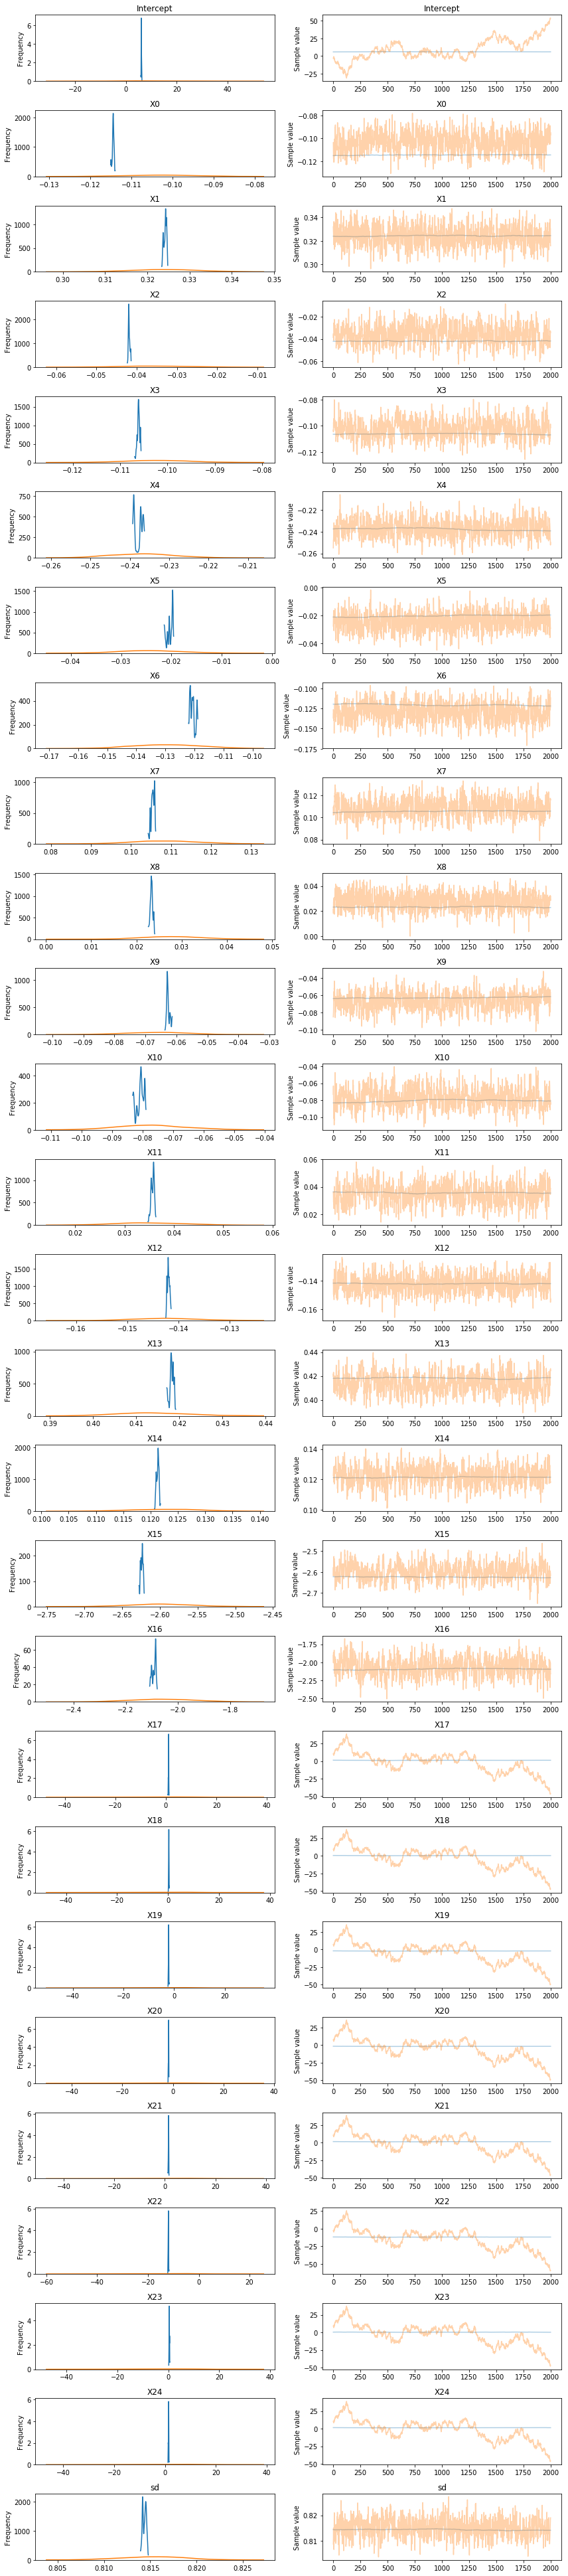

In [56]:
pm.traceplot(normal_trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2020e860>,
      dtype=object)

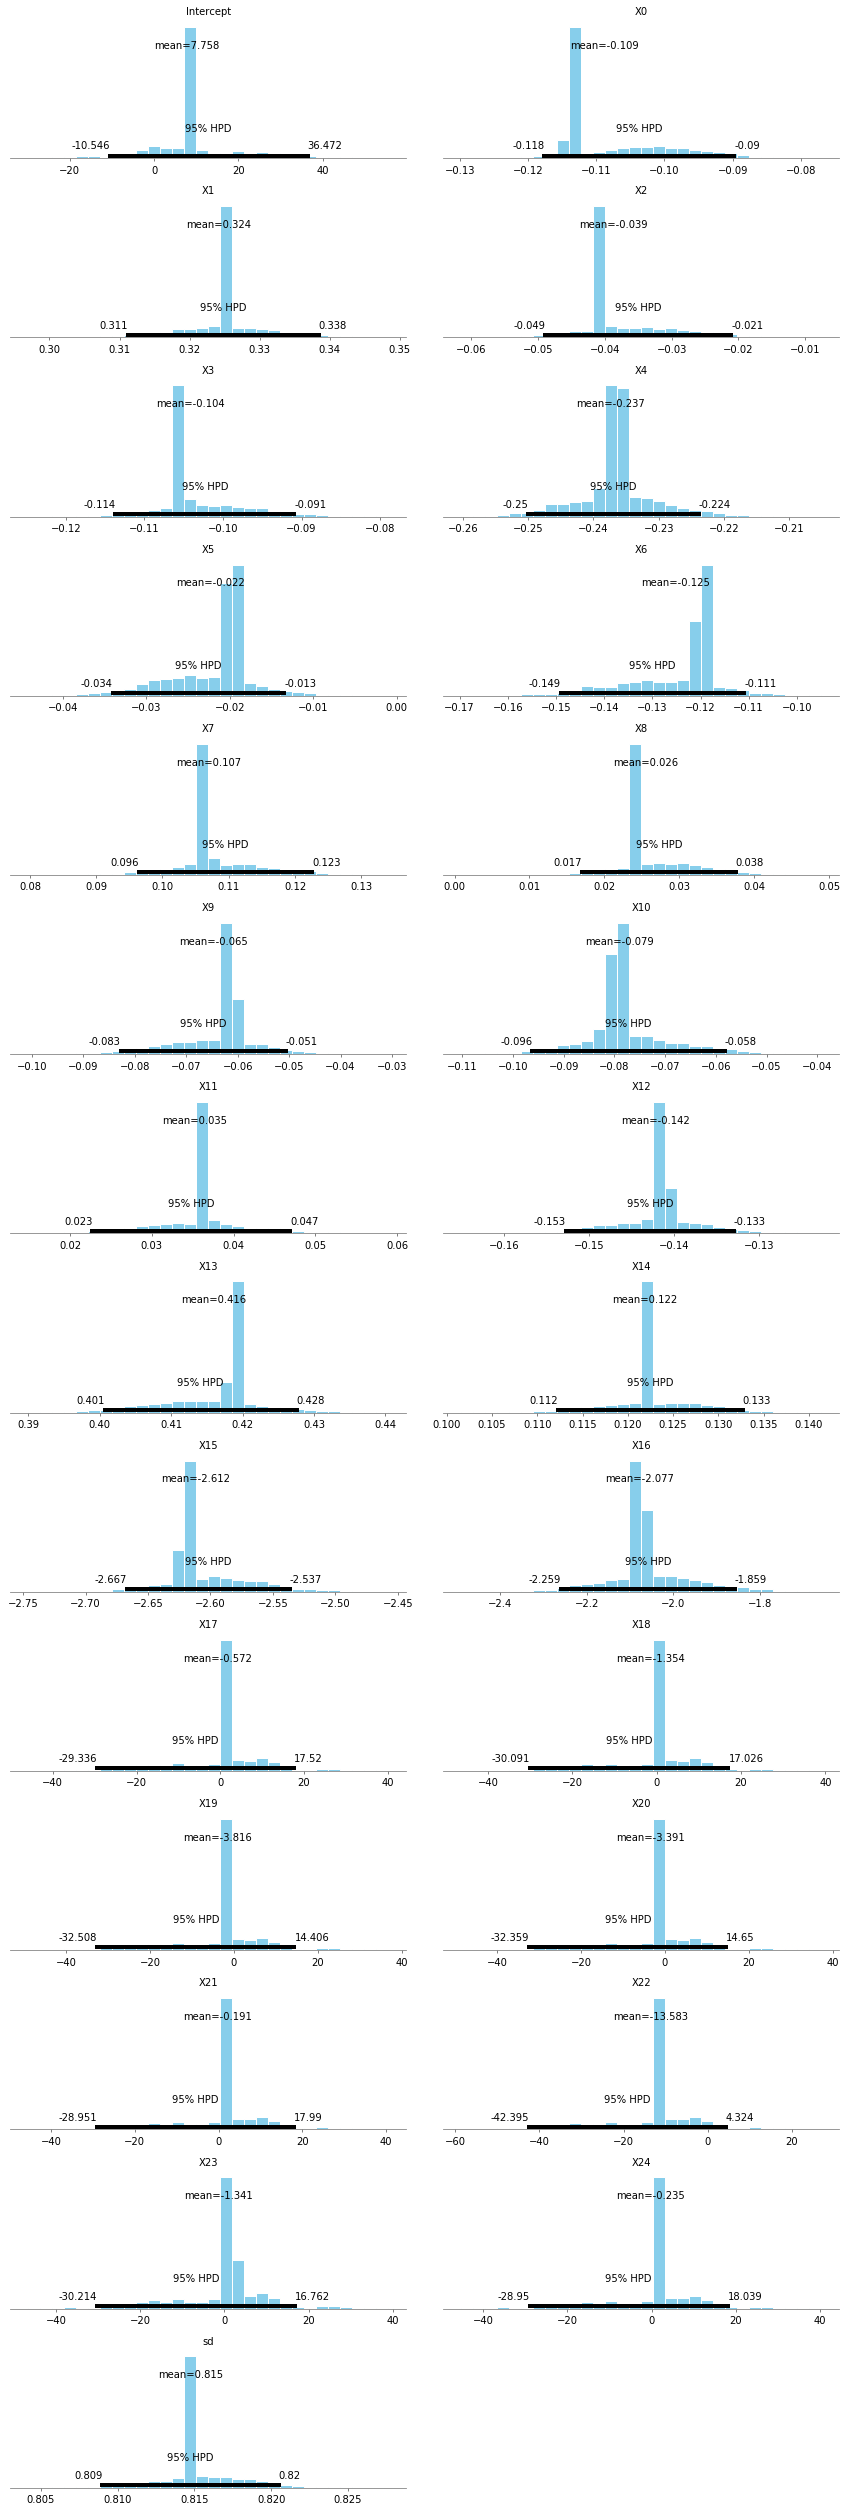

In [57]:
pm.plot_posterior(normal_trace)

In [59]:
model_formula = 'y = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'y =  7.76 * Intercept + -0.11 * X0 + 0.32 * X1 + -0.04 * X2 + -0.10 * X3 + -0.24 * X4 + -0.02 * X5 + -0.13 * X6 + 0.11 * X7 + 0.03 * X8 + -0.06 * X9 + -0.08 * X10 + 0.04 * X11 + -0.14 * X12 + 0.42 * X13 + 0.12 * X14 + -2.61 * X15 + -2.08 * X16 + -0.57 * X17 + -1.35 * X18 + -3.82 * X19 + -3.39 * X20 + -0.19 * X21 + -13.58 * X22 + -1.34 * X23 + -0.23 * X24 + -0.20 * sd_log__ + 0.81 * sd'

In [98]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_test):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    return results

In [99]:
results = evaluate_trace(normal_trace, features_train, features_test, windspeed_test)

Model  MAE: 0.6111
Model RMSE: 0.8411


### now we can use this model to make predictions with probability bounds

# A better model